# Speech emotion recognition on ravdess

In [1]:
import seaborn as sns

from src.utility import show_duration_distribution, plot_history, plot_clusters, plot_classes
from src.data_processing import FeatureExtractor
from src.dataset import Dataset

sns.set_theme()
speech_path, song_path, save_path = "data/raw/speech", "data/raw/song", "data/processed"
EPOCHS = 500

## Dataset analysis

### Audio duration
Plot of the average speech and song duration. The feature extractor fixes the len to the max len. 

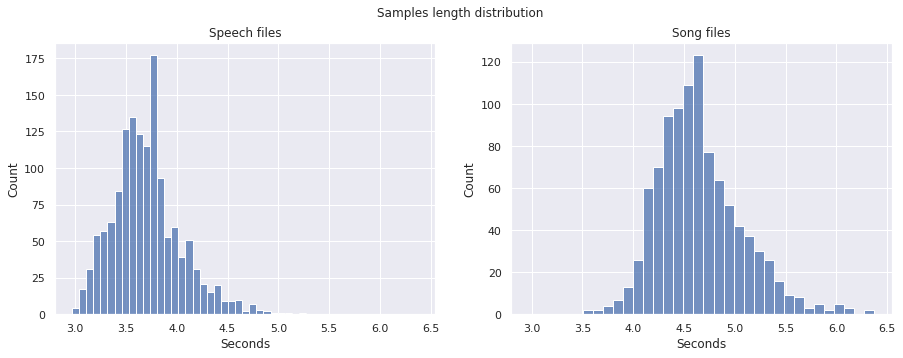

Max len of data samples:  6.3730612244897955


In [2]:
MAX_LEN = show_duration_distribution(speech_path, song_path, limit_per_actor=-1)
print("Max len of data samples: ", MAX_LEN)

### Preprocessing and feature extraction

Features...

In [3]:
MAX_LEN = 140526
fe = FeatureExtractor(speech_path=speech_path, 
                      song_path=song_path,
                      save_path=save_path, 
                      verbose=True, 
                      file_per_actor_limit=-1, 
                      audio_fixed_size=MAX_LEN)

data = fe.get_training_data(overwrite=False)

d = Dataset(data, augment=False)
X_train, X_val, X_test, y_train, y_val, y_test = d.get_training_data(data="merge", label="emotion", 
                                                                     train_perc=0.6, val_perc=0.2)
X_train.shape, X_val.shape, X_test.shape

Data found on disk


((1442, 312), (482, 312), (481, 312))

### Classes distribution

The class distribution is the following, this implies that we need to deal with imbalanced classes during training.

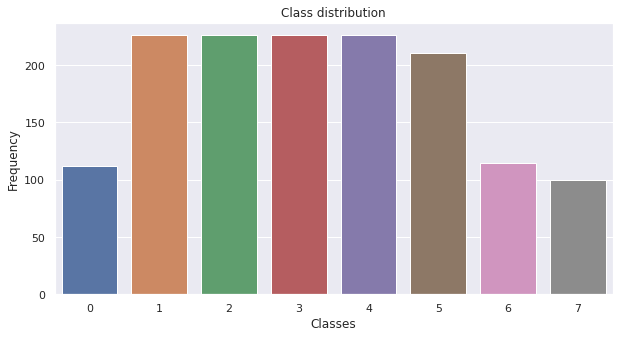

In [4]:
plot_classes(y_train)

### Clusters visualization
We extract the two features with most variance and plot the dataset clusters.

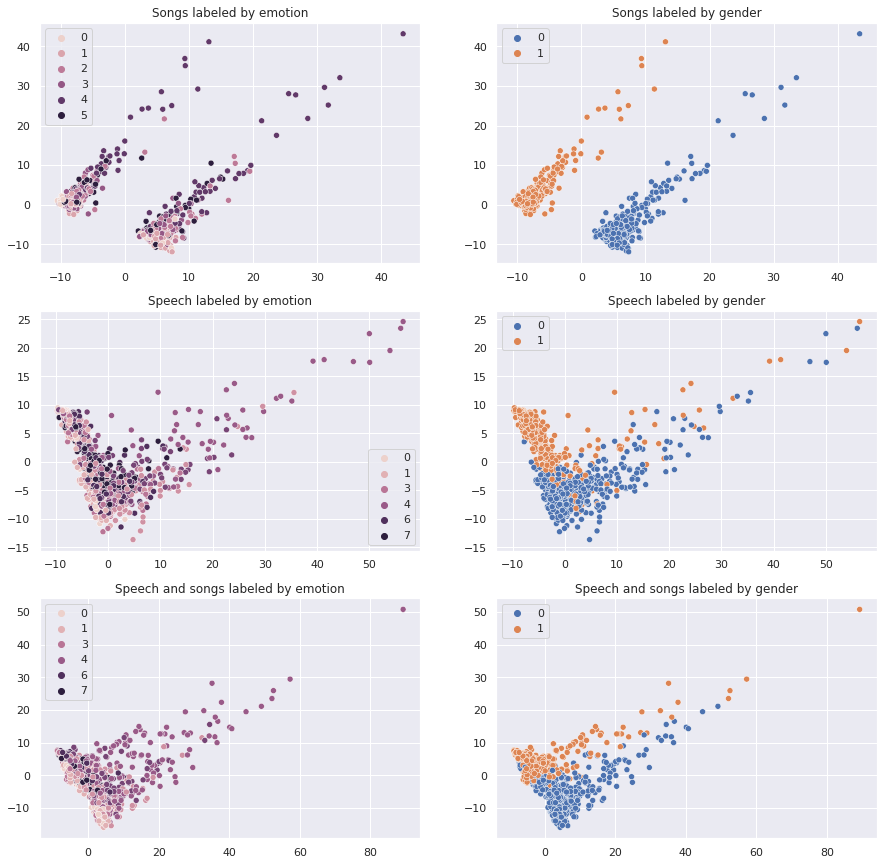

In [5]:
plot_clusters(Dataset(data, augment=False))

# SVM, K-NN and NN comparison

After extracting features, the first part of the project consists in comparing the performance of Neural Networks, SVM and K-NN. They are tested on the emotion label.

### SVM training

In [6]:
from sklearn.svm import SVC

x, _ = y_train.shape
x2, _ = y_val.shape
reshaped_y_train = y_train.reshape(x)
reshaped_y_val = y_val.reshape(x2)

svm_model = SVC()
svm_model.fit(X_train, reshaped_y_train)
print(f"SVM Accuracy on train: {svm_model.score(X_train, reshaped_y_train)}")
print(f"SVM Accuracy on validation:  {svm_model.score(X_val, reshaped_y_val)}")

SVM Accuracy on train: 0.8072122052704577
SVM Accuracy on validation:  0.6369294605809128


### KNN training
Here K is set to be sqrt of the number of training samples.

In [7]:
from sklearn.neighbors import KNeighborsClassifier as KNN

k = int(len(y_train)**(1/2))
k += int((k%2)==0)

knn_model = KNN(k)
knn_model.fit(X_train, reshaped_y_train)    

print(f"{k}-NN Accuracy on validation: {knn_model.score(X_val, reshaped_y_val)}")

37-NN Accuracy on validation: 0.491701244813278


### Neural network training
We now train a simple neural network on the data, evaluating the impact of using only audio, speech or both, each one with or without augmentation. 

Each test computes it's own class weights on the training data, the epochs are set to 300 and the model minimizing validation accuracy is selected. 

In [8]:
from prometheus_client import Counter
from sklearn.utils import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import L1, L2, L1L2

from collections import Counter
import numpy as np

def class_weight(y):
    seq = y.copy().reshape(y.shape[0])
    t, L = len(np.unique(seq)), len(seq)
    return {k : L/(t*v) for k, v in Counter(seq).items()}

def build_nn():
    model = Sequential()
    model.add(Input(shape=X_train[0].shape))
    model.add(Dense(150, activation="relu", kernel_regularizer=L1L2(l1=1e-5, l2=1e-4), bias_regularizer=L2(1e-4), activity_regularizer=L2(1e-5)))
    model.add(Dropout(0.1))  # <-- and here
    model.add(Dense(75, activation="relu", kernel_regularizer=L1L2(l1=1e-5, l2=1e-4), bias_regularizer=L2(1e-4), activity_regularizer=L2(1e-5)))
    model.add(Dropout(0.1))  # <-- and here
    model.add(Dense(8, activation="softmax"))
    model.compile(optimizer='sgd', loss=SparseCategoricalCrossentropy(), metrics=["accuracy"])
    return model

def train_nn(train_data, val_data, test_data, build_fun, epochs, verbose):
    
    m = build_fun()
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath="data/models/nn.hdf5",
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
    
    w = class_weight(train_data[1])
    history = m.fit(train_data[0], train_data[1], validation_data=val_data, 
                        epochs=epochs, verbose=verbose, callbacks=[model_checkpoint_callback], class_weight=w)
    plot_history(history)
    
    m.load_weights("data/models/nn.hdf5")
    l, a = m.evaluate(test_data[0], test_data[1], verbose=0)
    print(f"TEST: Loss: {l}, accuracy: {a}")
    return m, history


Audio files: song, augmentation: False


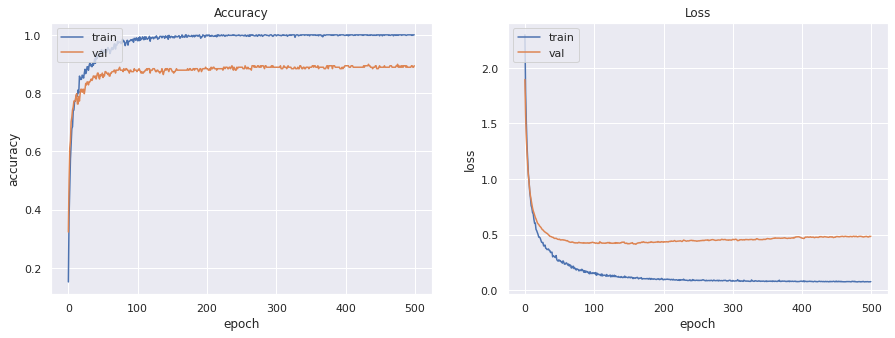

TEST: Loss: 0.4075639247894287, accuracy: 0.8939393758773804

Audio files: song, augmentation: True


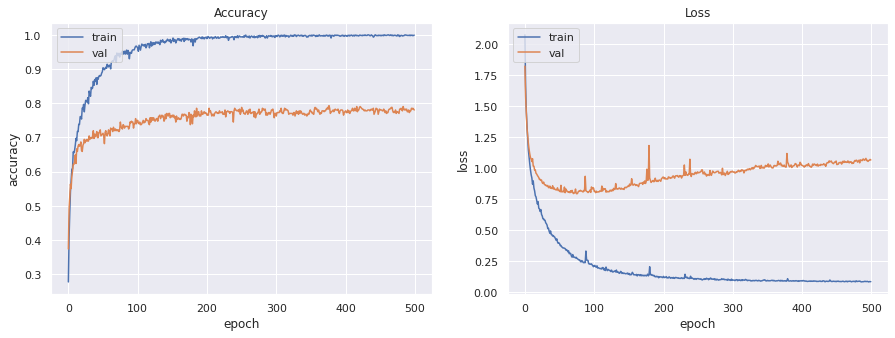

TEST: Loss: 0.49918314814567566, accuracy: 0.8585858345031738

Audio files: speech, augmentation: False


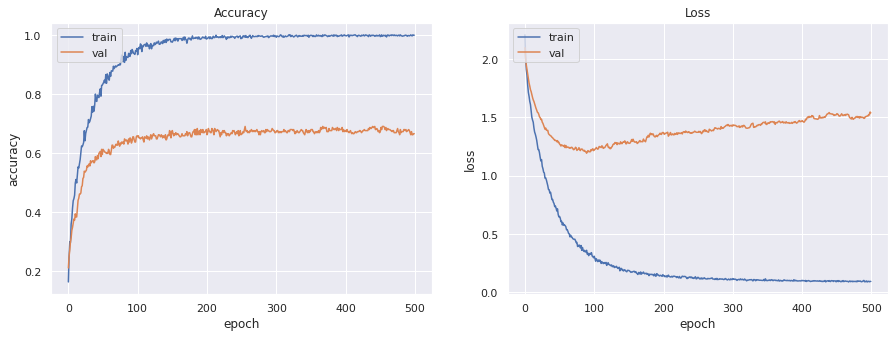

TEST: Loss: 1.5009095668792725, accuracy: 0.6267605423927307

Audio files: speech, augmentation: True


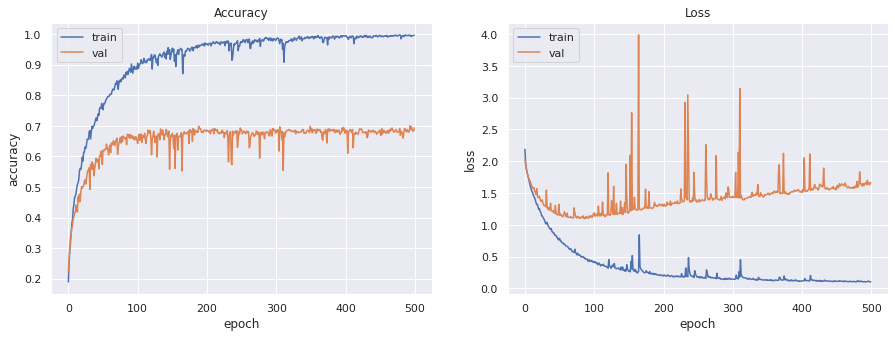

TEST: Loss: 1.9756900072097778, accuracy: 0.6478873491287231

Audio files: merge, augmentation: False


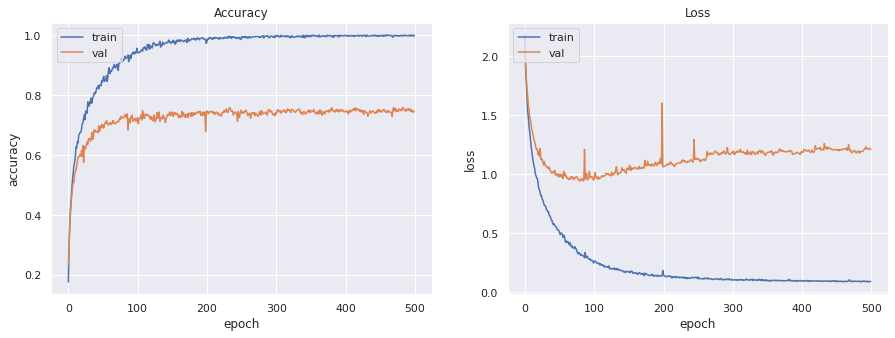

TEST: Loss: 0.9468477964401245, accuracy: 0.7463617324829102

Audio files: merge, augmentation: True


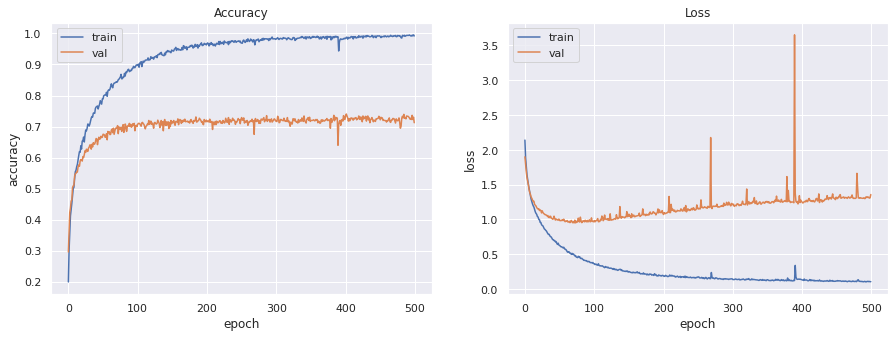

TEST: Loss: 1.299655556678772, accuracy: 0.7359667420387268


In [9]:
setups = zip(["song", "song", "speech", "speech", "merge", "merge"], [False, True]*3)

for mode in setups:
    print(f"\nAudio files: {mode[0]}, augmentation: {mode[1]}")
    X_train, X_val, X_test, y_train, y_val, y_test = Dataset(data, augment=mode[1])\
        .get_training_data(mode[0], "emotion", train_perc=0.6, val_perc=0.2)
    _, _ = train_nn((X_train, y_train), (X_val, y_val), (X_test, y_test), build_nn, epochs=EPOCHS, verbose=0)

### Observations
Performance on speech is much worse than song, this could mean that the feature extraction needs to be tuned for the first case. 
Augmentation seems pointless for song or speech classification, but it gives a small improvement on the merge case.

## Splitting the classification task

The idea is now to split the classification task, by first finding the gender or the vocal channel, and then perform classification on the sub problem. This could improve classification as the final task is simpler. The motivation behind this approach is the evident separability of gender in cluster visualization.

In [10]:
X_train, X_val, X_test, y_train, y_val, y_test = d.get_training_data("merge", "gender", train_perc=0.6, val_perc=0.2)

### Gender model 
Training a network to find gender of actor. This is a much easier task than before.

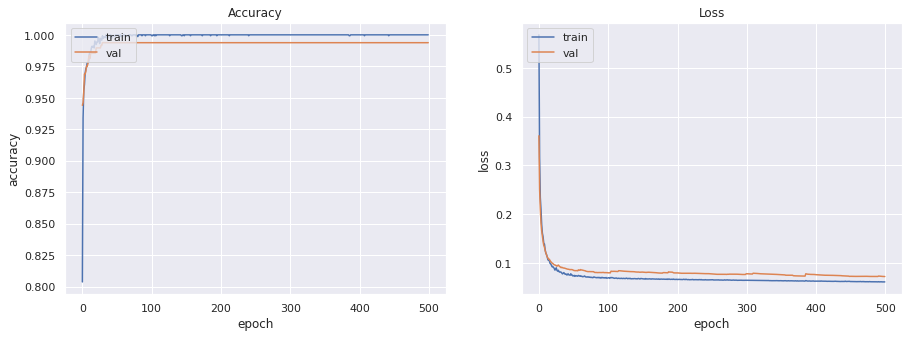

TEST: Loss: 0.11401441693305969, accuracy: 0.9854469895362854


In [11]:
def build_binary_nn():
    model = Sequential()
    model.add(Input(shape=X_train[0].shape))
    model.add(Dense(150, activation="relu", kernel_regularizer=L1L2(l1=1e-5, l2=1e-4), bias_regularizer=L2(1e-4), activity_regularizer=L2(1e-5)))
    model.add(Dropout(0.1))
    model.add(Dense(75, activation="relu", kernel_regularizer=L1L2(l1=1e-5, l2=1e-4), bias_regularizer=L2(1e-4), activity_regularizer=L2(1e-5)))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer='sgd', loss="binary_crossentropy", metrics=["accuracy"])
    return model

gender_network, _ = train_nn((X_train, y_train), (X_val, y_val), (X_test, y_test), build_binary_nn, epochs=EPOCHS, verbose=0)

### Male model 
The first model recognizes emotions from male speech and songs.

In [12]:
X_train, X_val, X_test, y_train, y_val, y_test = d.get_training_data("merge", "all", train_perc=0.6, val_perc=0.2)

def extract_gender_data(X, y):
    l = [[], []]
    for i, e in enumerate(y):
        l[e[2]].append(i)
        
    return X[l[0]], X[l[1]], y[l[0]], y[l[1]]

X_train_m, X_train_f, y_train_m, y_train_f = extract_gender_data(X_train, y_train)
X_val_m, X_val_f, y_val_m, y_val_f = extract_gender_data(X_val, y_val)
X_test_m, X_test_f, y_test_m, y_test_f = extract_gender_data(X_test, y_test)

# slicing and reshaping for later training
y_train_m = y_train_m[:, 0].reshape(y_train_m.shape[0], 1)
y_train_f = y_train_f[:, 0].reshape(y_train_f.shape[0], 1)
y_val_m = y_val_m[:, 0].reshape(y_val_m.shape[0], 1)
y_val_f = y_val_f[:, 0].reshape(y_val_f.shape[0], 1)
y_test_m = y_test_m[:, 0].reshape(y_test_m.shape[0], 1)
y_test_f = y_test_f[:, 0].reshape(y_test_f.shape[0], 1)

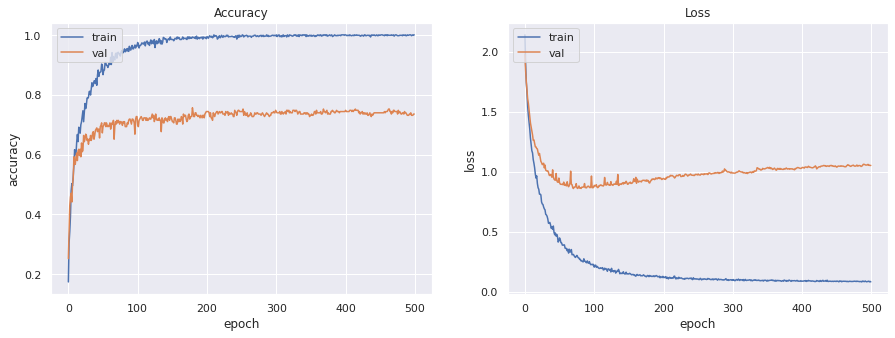

TEST: Loss: 0.849267840385437, accuracy: 0.7932489514350891


In [13]:
male_model, _ = train_nn((X_train_m, y_train_m), (X_val_m, y_val_m), (X_test_m, y_test_m), build_nn, epochs=EPOCHS, verbose=0)

### Female model 
The second model recognizes emotions from female speech and songs.

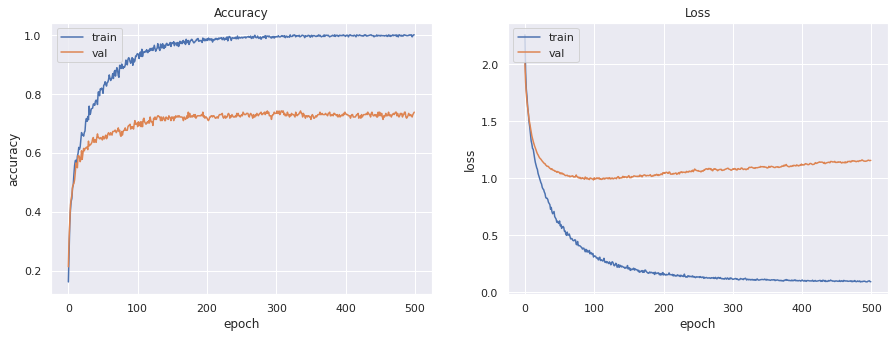

TEST: Loss: 0.9944520592689514, accuracy: 0.7131147384643555


In [14]:
female_model, _ = train_nn((X_train_f, y_train_f), (X_val_f, y_val_f), (X_test_f, y_test_f), build_nn, epochs=EPOCHS, verbose=0)

In [15]:
a = (0.7637130618095398 * len(y_test_m) + 0.7172130942344666 * len(y_test_f))/(len(y_test_m) + len(y_test_f))
print(f"Overall accuracy: {a}")

Overall accuracy: 0.7401247206695858


Overall, the result is not great and worse than before, it seems this is not the right way to tackle the problem.

## Learning embeddings via auto-encoders

The last try with this simple network architecture is to train auto-encoders to build the two layers, we are not considering gender this time, so results can be compared to the best accuracy so far: `0.74`

# Convolutional network on spectrogram

The last approach is to train a convolutional network on the audio spectrogram.